# Fake News Detection

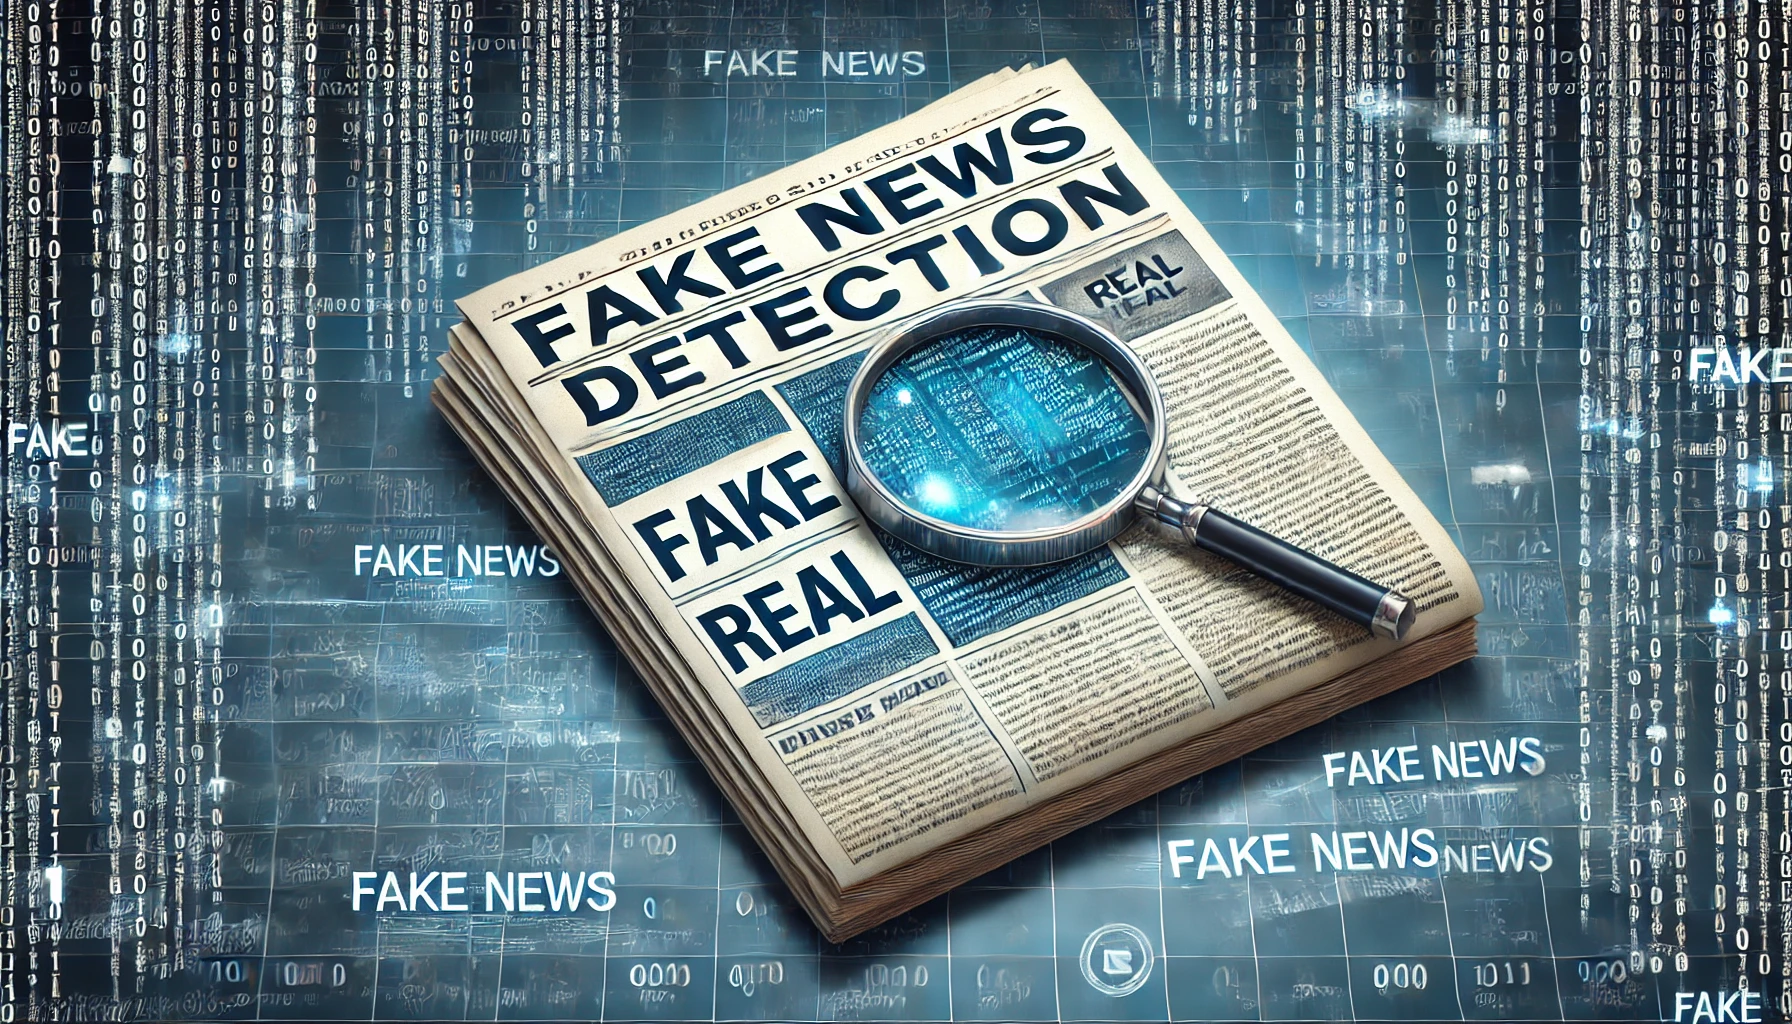

**Masoud Fattahi Bandpey**              <i> 2024 Aug</i>


#### Introduction

In an era where information is widely accessible, distinguishing between reliable and unreliable news has become increasingly important. The spread of misinformation, often referred to as "fake news," poses significant risks to public discourse and trust in media. This project aims to tackle this problem by developing a machine learning model that can identify fake news articles with high accuracy. Through data preprocessing, feature extraction, and model training, we will build a robust system capable of detecting fake news.

#### Dataset Description

The dataset used for this project contains news articles labeled as either "real" or "fake." It includes the following attributes:

- **id:** Unique identifier for each news article.
- **title:** The title of the news article.
- **author:** The author of the news article.
- **text:** The main content of the article, which might be incomplete.
- **label:** A binary label indicating the article's reliability (1 for unreliable/fake, 0 for reliable/real).

Understanding the structure and distribution of the dataset is crucial as it informs the preprocessing and modeling strategies.

### Step 1: Importing the Required Libraries

In this step, we import all the necessary libraries that will be used throughout the project. These libraries provide functionalities for data manipulation, text processing, model building, and evaluation.


In [ ]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')


### Step 2: Data Loading and Exploration

Before diving into model building, we need to load the dataset and perform some initial exploration to understand its structure and the distribution of labels.

#### Loading the Dataset

The dataset is loaded into a pandas DataFrame, which allows us to easily manipulate and analyze the data.


In [5]:
# Load the dataset
news_dataset = pd.read_csv('train.csv')

# Display the first few rows of the dataset to understand its structure
news_dataset.head()


Unnamed: 0                                              title  \
0        8476                       You Can Smell Hillary’s Fear   
1       10294  Watch The Exact Moment Paul Ryan Committed Pol...   
2        3608        Kerry to go to Paris in gesture of sympathy   
3       10142  Bernie supporters on Twitter erupt in anger ag...   
4         875   The Battle of New York: Why This Primary Matters   

                                                text label  
0  Daniel Greenfield, a Shillman Journalism Fello...  FAKE  
1  Google Pinterest Digg Linkedin Reddit Stumbleu...  FAKE  
2  U.S. Secretary of State John F. Kerry said Mon...  REAL  
3  — Kaydee King (@KaydeeKing) November 9, 2016 T...  FAKE  
4  It's primary day in New York and front-runners...  REAL

#### Checking for Missing Values

Missing data can cause issues during model training. We check for any missing values and decide on an appropriate strategy to handle them.


In [7]:
# Check for missing values
news_dataset.isnull().sum()

# Fill missing values with empty strings to avoid issues during text processing
news_dataset = news_dataset.fillna('')


#### Visualizing the Distribution of Labels

Understanding the balance between the classes (real vs. fake) is essential. If the dataset is imbalanced, it could affect the model's performance.


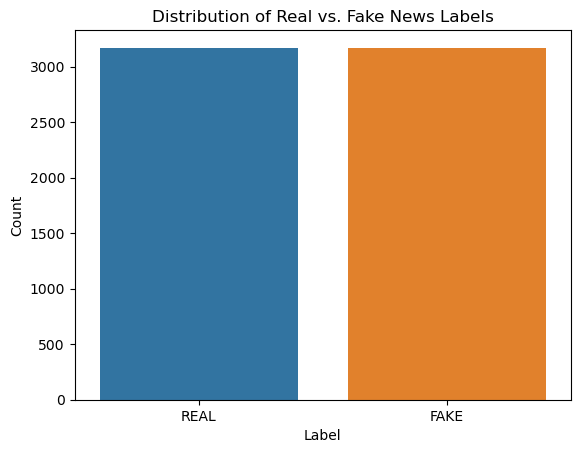

In [9]:
# Plot the distribution of labels
sns.countplot(data=news_dataset, x='label', order=news_dataset['label'].value_counts().index)
plt.title('Distribution of Real vs. Fake News Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


### Step 3: Data Preprocessing

Data preprocessing is a critical step in any machine learning project. In this part, we clean the text data and prepare it for vectorization.

#### Re-labeling

For consistency and easier interpretation, we re-label the `label` column to use numerical values (1 for real and 0 for fake).


In [11]:
# Re-labeling the dataset
news_dataset['label']=news_dataset['label'].map({'REAL': 1, 'FAKE' : 0})


#### Merging Title and Text Columns

To enhance the context available for classification, we merge the `title` and `text` columns into a new column named `body`.


In [13]:
# Merging 'title' and 'text' into a new column 'body'
news_dataset['body'] = news_dataset['text'] + ' ' + news_dataset['title']


In [27]:
news_dataset.drop(columns=['title','text'])

Unnamed: 0  label                                               body
0           8476      0  Daniel Greenfield, a Shillman Journalism Fello...
1          10294      0  Google Pinterest Digg Linkedin Reddit Stumbleu...
2           3608      1  U.S. Secretary of State John F. Kerry said Mon...
3          10142      0  — Kaydee King (@KaydeeKing) November 9, 2016 T...
4            875      1  It's primary day in New York and front-runners...
...          ...    ...                                                ...
6330        4490      1  The State Department told the Republican Natio...
6331        8062      0  The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
6332        8622      0   Anti-Trump Protesters Are Tools of the Oligar...
6333        4021      1  ADDIS ABABA, Ethiopia —President Obama convene...
6334        4330      1  Jeb Bush Is Suddenly Attacking Trump. Here's W...

[6335 rows x 3 columns]

#### Text Cleaning

Cleaning the text involves removing noise such as URLs, special characters, and stopwords, and converting the text to lowercase. This step helps in standardizing the text and improving the quality of features that will be extracted later.


In [34]:
def preprocess_text(review):
    review = re.sub(r'https?://\S+|www\.\S+', '', review)  # Remove URLs
    review = re.sub(r'\W', ' ', review)  # Remove special characters
    review = re.sub(r'\n', ' ', review)  # Replace newline characters with a space
    review = re.sub(r'\w*\d\w*', '', review)  # Remove words containing digits
    review = review.lower()  # Convert to lowercase
    review = nltk.word_tokenize(review)  # Tokenize
    
    corpus = [lemmatizer.lemmatize(word) for word in review if word not in stpwrds]  # Lemmatize and remove stopwords
    
    return ' '.join(corpus)  # Reconstruct the processed text

# Apply the preprocessing function to the 'body' column of the DataFrame
news_dataset['body'] = news_dataset['body'].apply(preprocess_text)


### Step 4: Feature Extraction

To train machine learning models, we need to convert the cleaned text into numerical features. This is done using the TF-IDF Vectorizer.

#### Separating Features and Labels

First, we separate the features (text) and labels (target) from the dataset.


In [38]:
# Separating features and labels
X = news_dataset['body'].values
Y = news_dataset['label'].astype('int').values


#### Splitting the Data

We split the data into training and testing sets to evaluate the model's performance. Stratification ensures that the training and test sets have a similar distribution of labels.


In [41]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)


#### TF-IDF Vectorization

TF-IDF (Term Frequency-Inverse Document Frequency) is used to convert the text data into numerical features. This technique considers the frequency of terms in the document while also accounting for their frequency across all documents, thus giving more weight to rare but important words.


In [44]:
# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_df=0.7, stop_words='english')
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)

# Display the shape of the vectorized features
print("Shape of TF-IDF training data:", tfidf_X_train.shape)


Shape of TF-IDF training data: (5068, 52266)


### Step 5: Model Training

In this step, we train multiple machine learning models and evaluate their performance. We'll use the following models:

1. **Decision Tree Classifier**
2. **Passive Aggressive Classifier**
3. **XGBoost Classifier**
4. **Random Forest Classifier**
5. **Neural Network Model**

#### Step 5.1: Decision Tree Classifier

The Decision Tree Classifier is a simple yet powerful model that works by splitting the data based on certain criteria, aiming to maximize the separation between classes.


Decision Tree Accuracy: 0.8034727703235991


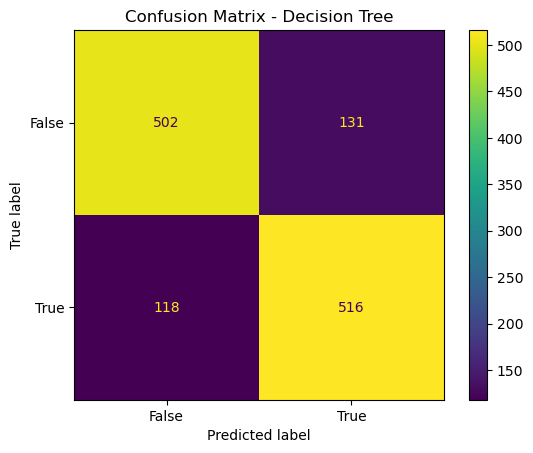

In [47]:
# Train the Decision Tree Classifier
decision_model = DecisionTreeClassifier()
decision_model.fit(tfidf_X_train, Y_train)

# Predict and evaluate
Y_test_pred = decision_model.predict(tfidf_X_test)
test_accuracy = accuracy_score(Y_test_pred, Y_test)
print('Decision Tree Accuracy:', test_accuracy)

# Confusion Matrix
cm = metrics.confusion_matrix(Y_test, Y_test_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.title('Confusion Matrix - Decision Tree')
plt.show()


#### Step 5.2: Passive Aggressive Classifier

The Passive Aggressive Classifier is particularly suited for large-scale learning tasks. It remains passive on correct classification but aggressively updates on incorrect classification, making it ideal for binary classification tasks like fake news detection.


Passive Aggressive Accuracy: 93.45%


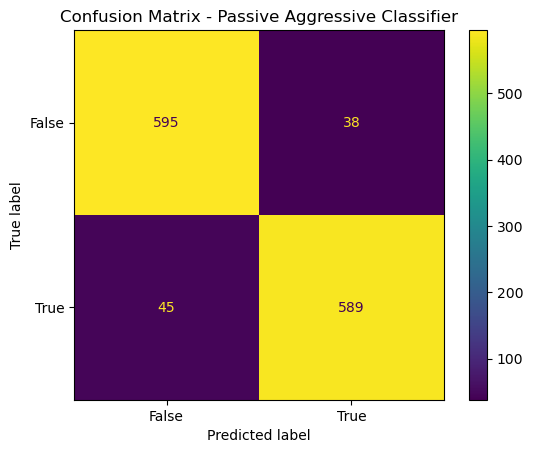

In [50]:
# Train the Passive Aggressive Classifier
classifier = PassiveAggressiveClassifier(max_iter=1000)
classifier.fit(tfidf_X_train, Y_train)

# Predict and evaluate
Y_pred = classifier.predict(tfidf_X_test)
score = metrics.accuracy_score(Y_test, Y_pred)
print(f'Passive Aggressive Accuracy: {round(score * 100, 2)}%')

# Confusion Matrix
cm = metrics.confusion_matrix(Y_test, Y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.title('Confusion Matrix - Passive Aggressive Classifier')
plt.show()


#### Step 5.3: XGBoost Classifier

XGBoost is a powerful gradient boosting algorithm known for its efficiency and accuracy. It is particularly useful in handling large datasets and can capture complex patterns in the data.


XGBoost Accuracy: 86.90%


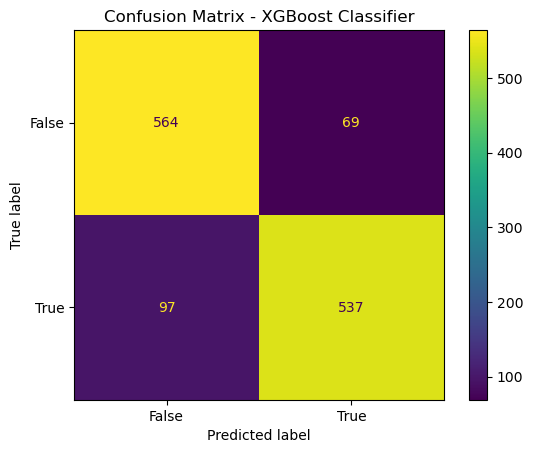

In [53]:
# Train the XGBoost Classifier
xgb_model = XGBClassifier(
    learning_rate=0.001,
    n_estimators=1000,
    max_depth=10,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=42,
    gamma=0.01,
    reg_lambda=0.1
)
xgb_model.fit(tfidf_X_train, Y_train)

# Predict and evaluate
Y_pred_xgb = xgb_model.predict(tfidf_X_test)
predictions = [round(value) for value in Y_pred_xgb]
accuracy = accuracy_score(Y_test, predictions)
print("XGBoost Accuracy: %.2f%%" % (accuracy * 100.0))

# Confusion Matrix
cm = metrics.confusion_matrix(Y_test, Y_pred_xgb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()


#### Step 5.4: Random Forest Classifier

The Random Forest Classifier is an ensemble learning method that operates by constructing multiple decision trees during training. It is known for its robustness and ability to handle both classification and regression tasks effectively.


Random Forest Accuracy: 90.21%


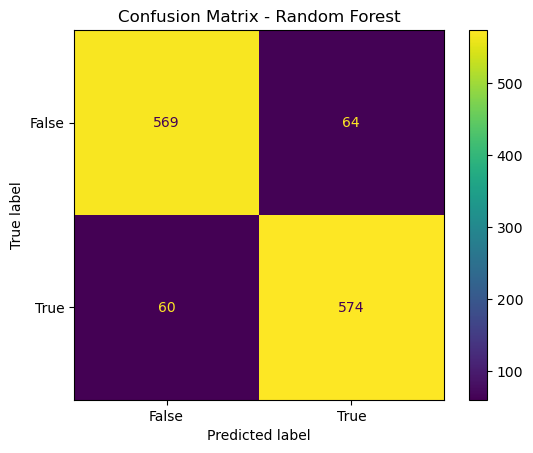

In [62]:
# Train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(tfidf_X_train, Y_train)

# Predict and evaluate
Y_pred_rf = rf_model.predict(tfidf_X_test)
rf_accuracy = accuracy_score(Y_test, Y_pred_rf)
print("Random Forest Accuracy: {:.2f}%".format(rf_accuracy * 100))

# Confusion Matrix
cm = metrics.confusion_matrix(Y_test, Y_pred_rf)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.title('Confusion Matrix - Random Forest')
plt.show()


#### Step 5.5: Neural Network Model

Neural networks, particularly deep learning models, have shown remarkable performance in text classification tasks. Here, we define a simple feedforward neural network (Multi-Layer Perceptron) to see how it performs on this fake news detection task.


C:\Users\masoud\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
80/80 - 21s - 257ms/step - accuracy: 0.8528 - loss: 0.3468 - val_accuracy: 0.9353 - val_loss: 0.1710
Epoch 2/10
80/80 - 17s - 212ms/step - accuracy: 0.9858 - loss: 0.0503 - val_accuracy: 0.9345 - val_loss: 0.1680
Epoch 3/10
80/80 - 18s - 219ms/step - accuracy: 0.9986 - loss: 0.0073 - val_accuracy: 0.9337 - val_loss: 0.1920
Epoch 4/10
80/80 - 20s - 248ms/step - accuracy: 0.9996 - loss: 0.0018 - val_accuracy: 0.9376 - val_loss: 0.1933
Epoch 5/10
80/80 - 17s - 216ms/step - accuracy: 1.0000 - loss: 6.3281e-04 - val_accuracy: 0.9384 - val_loss: 0.2001
Epoch 6/10
80/80 - 18s - 219ms/step - accuracy: 1.0000 - loss: 3.4948e-04 - val_accuracy: 0.9392 - val_loss: 0.2089
Epoch 7/10
80/80 - 20s - 252ms/step - accuracy: 1.0000 - loss: 2.1257e-04 - val_accuracy: 0.9369 - val_loss: 0.2158
Epoch 8/10
80/80 - 17s - 217ms/step - accuracy: 1.0000 - loss: 1.4271e-04 - val_accuracy: 0.9384 - val_loss: 0.2232
Epoch 9/10
80/80 - 17s - 215ms/step - accuracy: 1.0000 - loss: 1.2539e-04 - val_accuracy

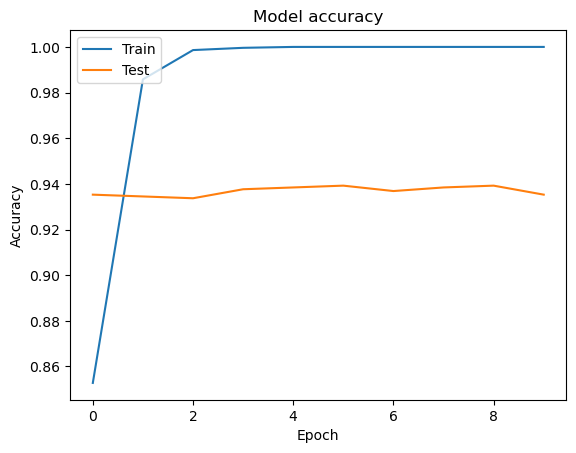

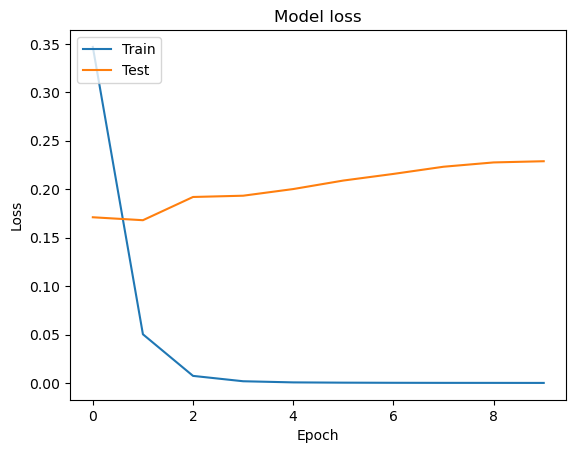

In [64]:
# Define the neural network architecture
model = Sequential()
model.add(Dense(512, input_dim=tfidf_X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(tfidf_X_train, Y_train, epochs=10, batch_size=64, validation_data=(tfidf_X_test, Y_test), verbose=2)

# Evaluate the model
nn_accuracy = model.evaluate(tfidf_X_test, Y_test, verbose=0)[1]
print("Neural Network Accuracy: {:.2f}%".format(nn_accuracy * 100))

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


### Step 6: Model Comparison

After training all the models, we compare their performance using a simple table. This will allow us to see which model performed the best in terms of accuracy.


In [66]:
# Compile the results into a DataFrame for easy comparison
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Passive Aggressive', 'XGBoost', 'Random Forest', 'Neural Network'],
    'Accuracy': [
        test_accuracy * 100,  # Decision Tree accuracy
        score * 100,          # Passive Aggressive accuracy
        accuracy * 100,       # XGBoost accuracy
        rf_accuracy * 100,    # Random Forest accuracy
        nn_accuracy * 100     # Neural Network accuracy
    ]
})

# Display the comparison table
print(results)


                Model   Accuracy
0       Decision Tree  80.347277
1  Passive Aggressive  93.449092
2             XGBoost  86.898185
3       Random Forest  90.213102
4      Neural Network  93.528020


### Step 7: Making a Predictive System

Once the models are trained, we create a function to predict whether a given news article is real or fake. This function will be useful for making predictions on new, unseen data.


In [70]:
def fake_news_detector(news):
    input_data = [news]
    vectorized_input_data = vectorizer.transform(input_data)
    prediction = model.predict(vectorized_input_data)
    if prediction[0] == 0:
        print("Looks like a FAKE News")
    else:
        print("Looks like a REAL News")


#### Testing the Predictive System

We can test the system with a few examples to see how well it performs.


In [75]:
# Test the system
fake_news_detector("Go to Article President Barack Obama has been campaigning hard for the woman who is supposedly going to extend his legacy four more years.")
fake_news_detector("U.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Looks like a REAL News
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Looks like a REAL News


### Step 8: Model Persistence

After training and testing the models, we save the best-performing model and the vectorizer using `pickle`. This allows us to load and use the model later without needing to retrain it.

#### Saving the Model and Vectorizer


In [77]:
# Save the model and vectorizer
pickle.dump(model, open('model.pkl', 'wb'))
pickle.dump(vectorizer, open('tfidfvect.pkl', 'wb'))


#### Loading and Using the Saved Model

We can load the saved model and vectorizer to make predictions on new data.


In [79]:
# Load the model and vectorizer
model = pickle.load(open('model.pkl', 'rb'))
vect = pickle.load(open('tfidfvect.pkl', 'rb'))

# Example usage
news = "Some example news text"
val_pkl = vect.transform([news]).toarray()
pred_pkl = model.predict(val_pkl)
if pred_pkl[0] == 0:
    print("Looks like a FAKE News")
else:
    print("Looks like a REAL News")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Looks like a REAL News


### Conclusion

In this project, we explored various machine learning models to detect fake news, including Decision Tree, Passive Aggressive, XGBoost, Random Forest, and a Neural Network. The models were evaluated based on their accuracy, and the results are summarized below:

| Model                 | Accuracy (%) |
|-----------------------|--------------|
| Decision Tree         | 80.35        |
| Passive Aggressive    | 93.45        |
| XGBoost               | 86.90        |
| Random Forest         | 90.21        |
| Neural Network        | 93.53        |

#### Key Insights:

1. **Neural Network:** The neural network model achieved the highest accuracy at 93.53%, slightly outperforming the other models. This indicates that deep learning models, with their ability to capture complex patterns in data, can be particularly effective for text classification tasks such as fake news detection.

2. **Passive Aggressive Classifier:** With an accuracy of 93.45%, the Passive Aggressive Classifier also performed exceptionally well. It is a fast and efficient model, especially suited for large-scale learning tasks. This model’s performance is nearly on par with the neural network, making it an excellent choice for scenarios where computational efficiency is a priority.

3. **Random Forest:** The Random Forest model achieved an accuracy of 90.21%. While not as high as the neural network or Passive Aggressive Classifier, it still demonstrates strong performance. Random Forest is known for its robustness and ability to handle overfitting, making it a reliable option when model interpretability is also important.

4. **XGBoost:** The XGBoost model achieved an accuracy of 86.90%. XGBoost is a powerful boosting algorithm that generally performs well on structured data. Although it did not outperform the other models in this case, it remains a strong candidate for scenarios where boosting methods are preferred.

5. **Decision Tree:** The Decision Tree model had the lowest accuracy at 80.35%. While Decision Trees are easy to interpret and can handle non-linear data well, they are prone to overfitting, which likely contributed to the lower performance compared to the other models.

#### Final Recommendation:

Based on the accuracy results, the **Neural Network** and **Passive Aggressive Classifier** are the top-performing models for fake news detection. Both models offer a good balance between accuracy and generalization ability. The slight edge in accuracy makes the neural network model a compelling choice, especially in scenarios where maximizing prediction accuracy is critical.

However, the **Passive Aggressive Classifier** remains a strong contender due to its efficiency and simplicity. If computational resources are limited or if fast predictions are required, this model would be an excellent choice.

For applications where model interpretability and robustness are prioritized, the **Random Forest** model is recommended, offering good accuracy with a more straightforward decision-making process.

### Future Work:

- **Model Ensembling:** Combining the strengths of multiple models, such as an ensemble of the neural network and Passive Aggressive Classifier, could potentially lead to even better performance.
  
- **Deep Learning Exploration:** Further exploring advanced neural network architectures, such as LSTMs or CNNs, could yield improvements, particularly in capturing contextual information in text data.
  
- **Hyperparameter Tuning:** Fine-tuning the hyperparameters of the existing models could enhance their performance further.
  
- **Real-Time Deployment:** Implementing the best-performing model in a real-time detection system could provide immediate benefits in identifying and mitigating the spread of fake news.
